In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import json
from itertools import groupby

import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import draw_plan, blit_rooms
from minimal.layout import NodeType, NODE_COLOR, NODE_NAME
from minimal import sample_graphs
from minimal.gen import _load_segmentation_dict
from minimal.lib import gen_segmentation_mask, assemble_plan
from minimal.doors import create_cut_wall_mask

%matplotlib inline

In [3]:
layout, masks = _load_segmentation_dict(torch.load("data/sgm_01.pth"))

In [18]:
# layout = sample_graphs.two()

In [20]:
# %%time

# masks = gen_segmentation_mask(layout)

CPU times: user 1min 24s, sys: 9.32 s, total: 1min 33s
Wall time: 26.7 s


In [4]:
scale = (3, 3)

In [5]:
%%time

rect_graphs, sep_mask, doors = assemble_plan(layout, masks, scale)

CPU times: user 1.56 s, sys: 12.7 ms, total: 1.57 s
Wall time: 1.47 s


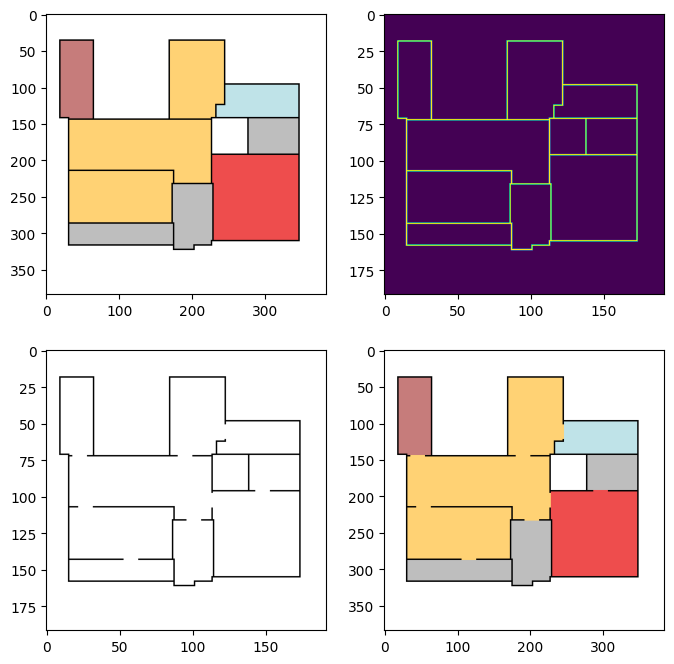

In [6]:
walls = create_cut_wall_mask(sep_mask, doors)

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.imshow(blit_rooms(rect_graphs, sep_mask, out_size=384))

plt.subplot(222)
plt.imshow((sep_mask > 0).byte())

plt.subplot(223)
plt.imshow(1 - walls, cmap="gray")

plt.subplot(224)
plt.imshow(blit_rooms(rect_graphs, walls, out_size=384))

In [7]:
rect_graphs, sep_mask, doors

([<minimal.rooms.RectGraph at 0x713a640c8610>,
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 [(116, 96, 10, 'h'),
  (96, 143, 10, 'h'),
  (72, 90, 10, 'h'),
  (51, 122, 10, 'v'),
  (72, 18, 10, 'h'),
  (98, 113, 10, 'v'),
  (143, 53, 10, 'h'),
  (107, 22, 10, 'h')])

In [21]:
rooms_encoded = []
for i, r in enumerate(rect_graphs):
    room_data = [r.room_type]
    for _, d in r.rects_graph.nodes(data=True):
        room_data.extend(d['xywh'])

    rooms_encoded.append(room_data)

In [41]:
sep_mask_encoded = {
    'shape': tuple(sep_mask.shape),
    'data': sep_mask.view(-1).tolist()
}

In [58]:
print(scale, doors)

(3, 3) [(116, 96, 10, 'h'), (96, 143, 10, 'h'), (72, 90, 10, 'h'), (51, 122, 10, 'v'), (72, 18, 10, 'h'), (98, 113, 10, 'v'), (143, 53, 10, 'h'), (107, 22, 10, 'h')]


In [70]:
plan_json = json.dumps({
    "scale": scale,
    "rooms": rooms_encoded,
    "sep_mask": sep_mask_encoded,
    "doors": doors
})

In [71]:
with open("plan.json", "w") as f:
    f.write(plan_json)